# Out-of-the-📦 FP8 Training

A demo of the `unit_scaling` library, showing a simple method for making models easy to train in FP8.

💻 **Try the library**: [graphcore-research.github.io/unit-scaling](https://graphcore-research.github.io/unit-scaling/)

📖 **Read the paper**: [arxiv.org/abs/2303.11257](https://arxiv.org/abs/2303.11257)

## TL;DR

Naïvely casting to FP8 causes training to fail as some values go out-of-range.
This can be easily fixed by using unit-scaled layers.

`unit_scaling` provides simple transforms to a) simulate FP8 matmuls, b) automatically unit-scale models. We apply this to Karpathy's nanoGPT:

number of parameters: 10.67M


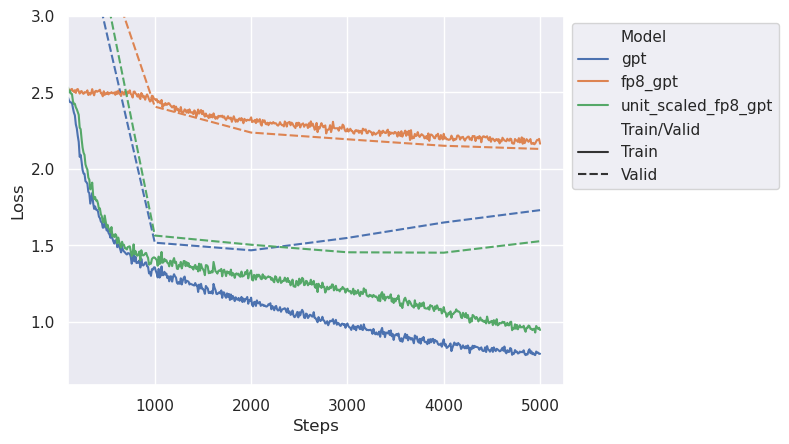

In [2]:
from nanoGPT.model import GPT
from notebook_utils import config, train
from unit_scaling.transforms import simulate_fp8, unit_scale

gpt = GPT(config)  # model unchanged from original nanoGPT
fp8_gpt = simulate_fp8(gpt)
unit_scaled_fp8_gpt = unit_scale(fp8_gpt)

models = [gpt, fp8_gpt, unit_scaled_fp8_gpt]
for model in models:
    df = train(model)

Training the unmodified model in FP8 causes significant degradation. By applying the unit scaling transform we're able to recover the full validation accuracy of the original model*.

This transform can be applied to arbitrary pytorch models, or implemented manually, with zero overhead when used with `torch.compile`**.

What follows is a step-by-step guide on the problem of naïvely running in FP8 and how the `unit_scaling` library can be used to address this.

*_as seen in the literature (e.g. [Noune et al., 2022](https://arxiv.org/abs/2206.02915)), FP8 lacks precision to maintain full training accuracy_.

**_see our [Benchmarking Compiled Unit-Scaled Ops](https://github.com/graphcore-research/unit-scaling/blob/main/analysis/benchmarking_compiled_unit_scaled_ops.ipynb) notebook for a full analysis of the (lack of) overhead when using `unit_scaling`._

---

## The base model

[TODO]

1. Explain what the base model is, why we chose it, that method doesn't depend on model
2. Explain training procedure (i.e. just do what Karpathy does)
4. Works on any hardware that supports PyTorch
5. Show baseline curves (train & valid)

## Naïve FP8

[TODO]

1. Benefits of FP8
2. Challenges of FP8
3. Previous approaches to FP8 training (pros/cons)
4. Explain simulated FP8 wrapper
5. Show plot with baseline and naïve FP8
6. Present analysis tool and show/explain issue using plot

<Axes: title={'center': 'gpt'}, xlabel='mean absolute value', ylabel='layer'>

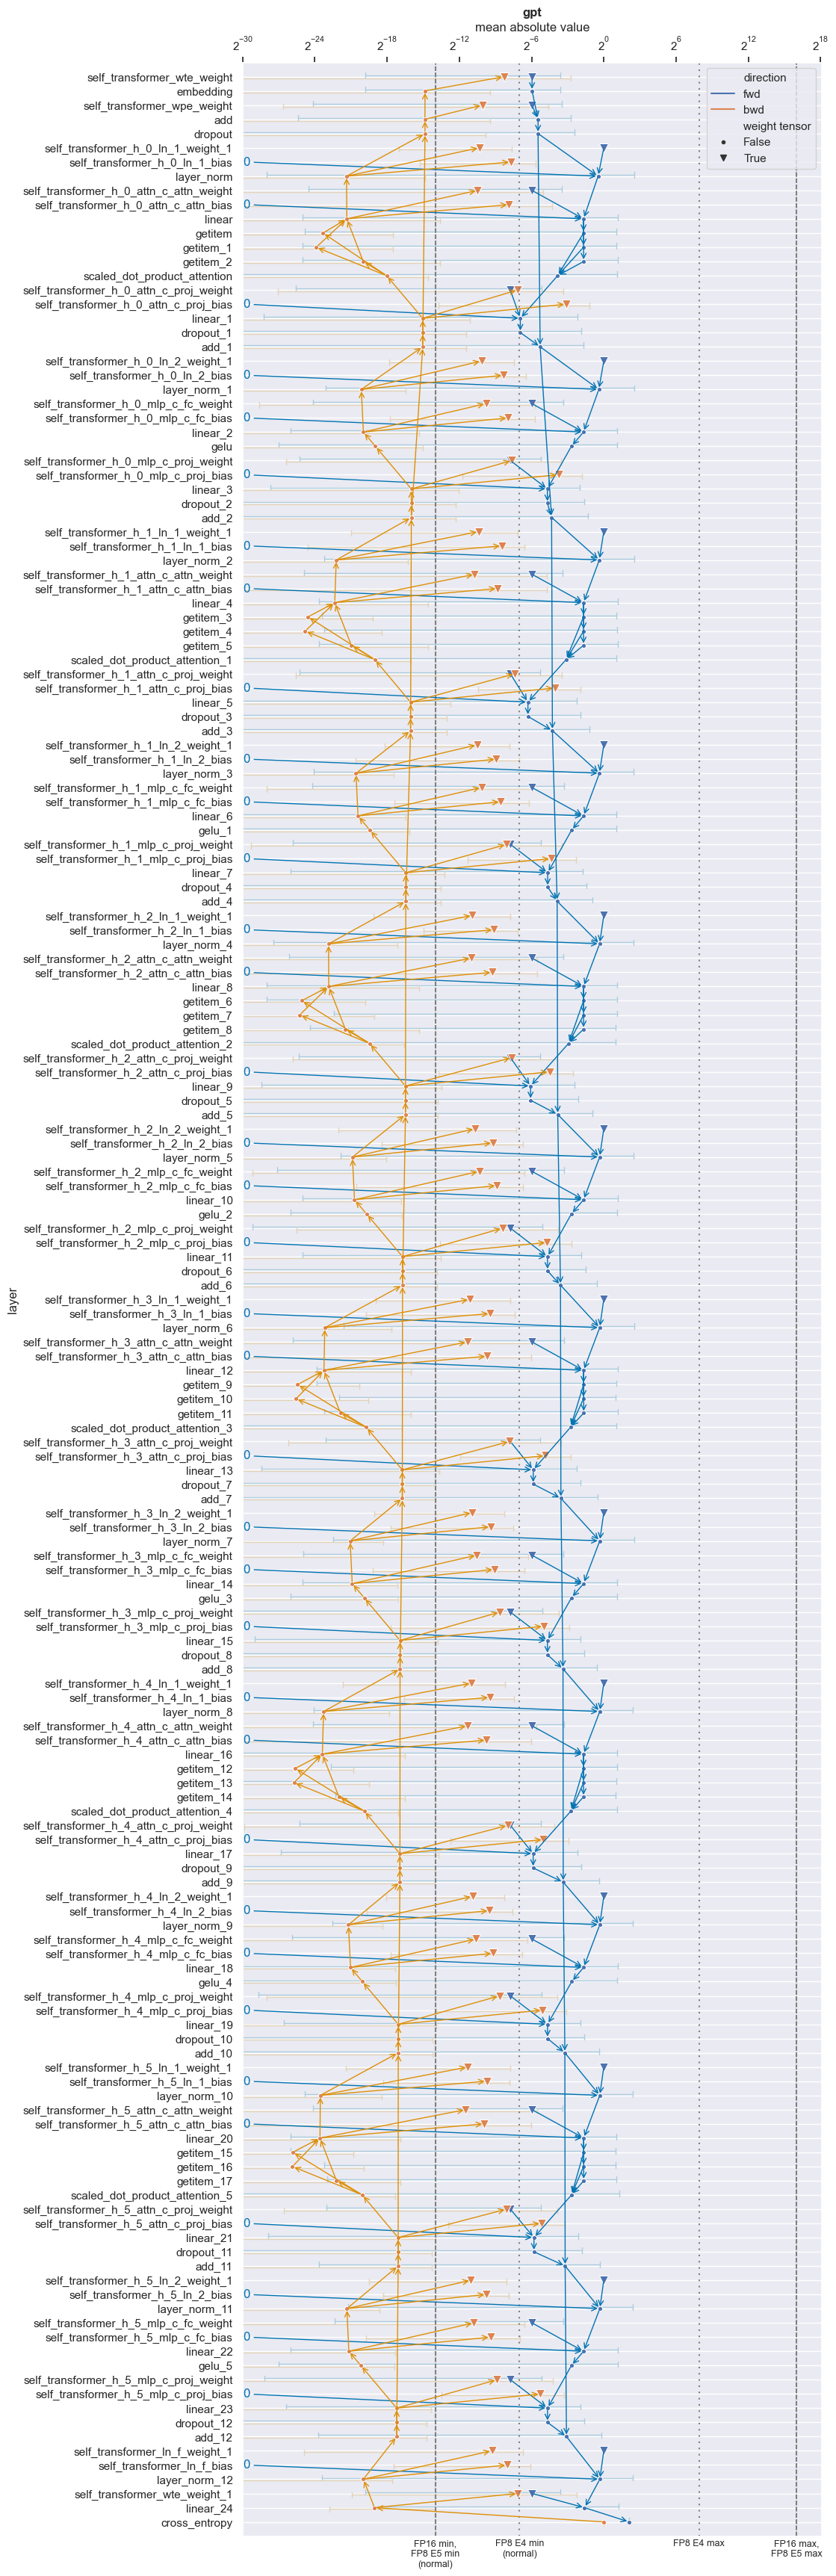

In [10]:
from notebook_utils import demo_data
from unit_scaling.transforms import track_scales
from unit_scaling import analysis

inputs, labels = demo_data(batch_size=64)

tracked_gpt = track_scales(gpt)
out, loss = tracked_gpt(inputs, labels)
loss.backward()

graph = tracked_gpt.scales_graph()  # type: ignore
analysis.plot(graph, "gpt", xmin=2**-30)

## Unit scaling + FP8

[TODO]

1. Explain unit scaling method
2. Show how it would be implemented manually
3. Show the wrapper and explain how it works (with caveats)
4. Explain benefits vs other approaches and lack of overheads
5. Re-show plot with all 3 results
6. Show scales post-training?

<Axes: title={'center': 'gpt'}, xlabel='mean absolute value', ylabel='layer'>

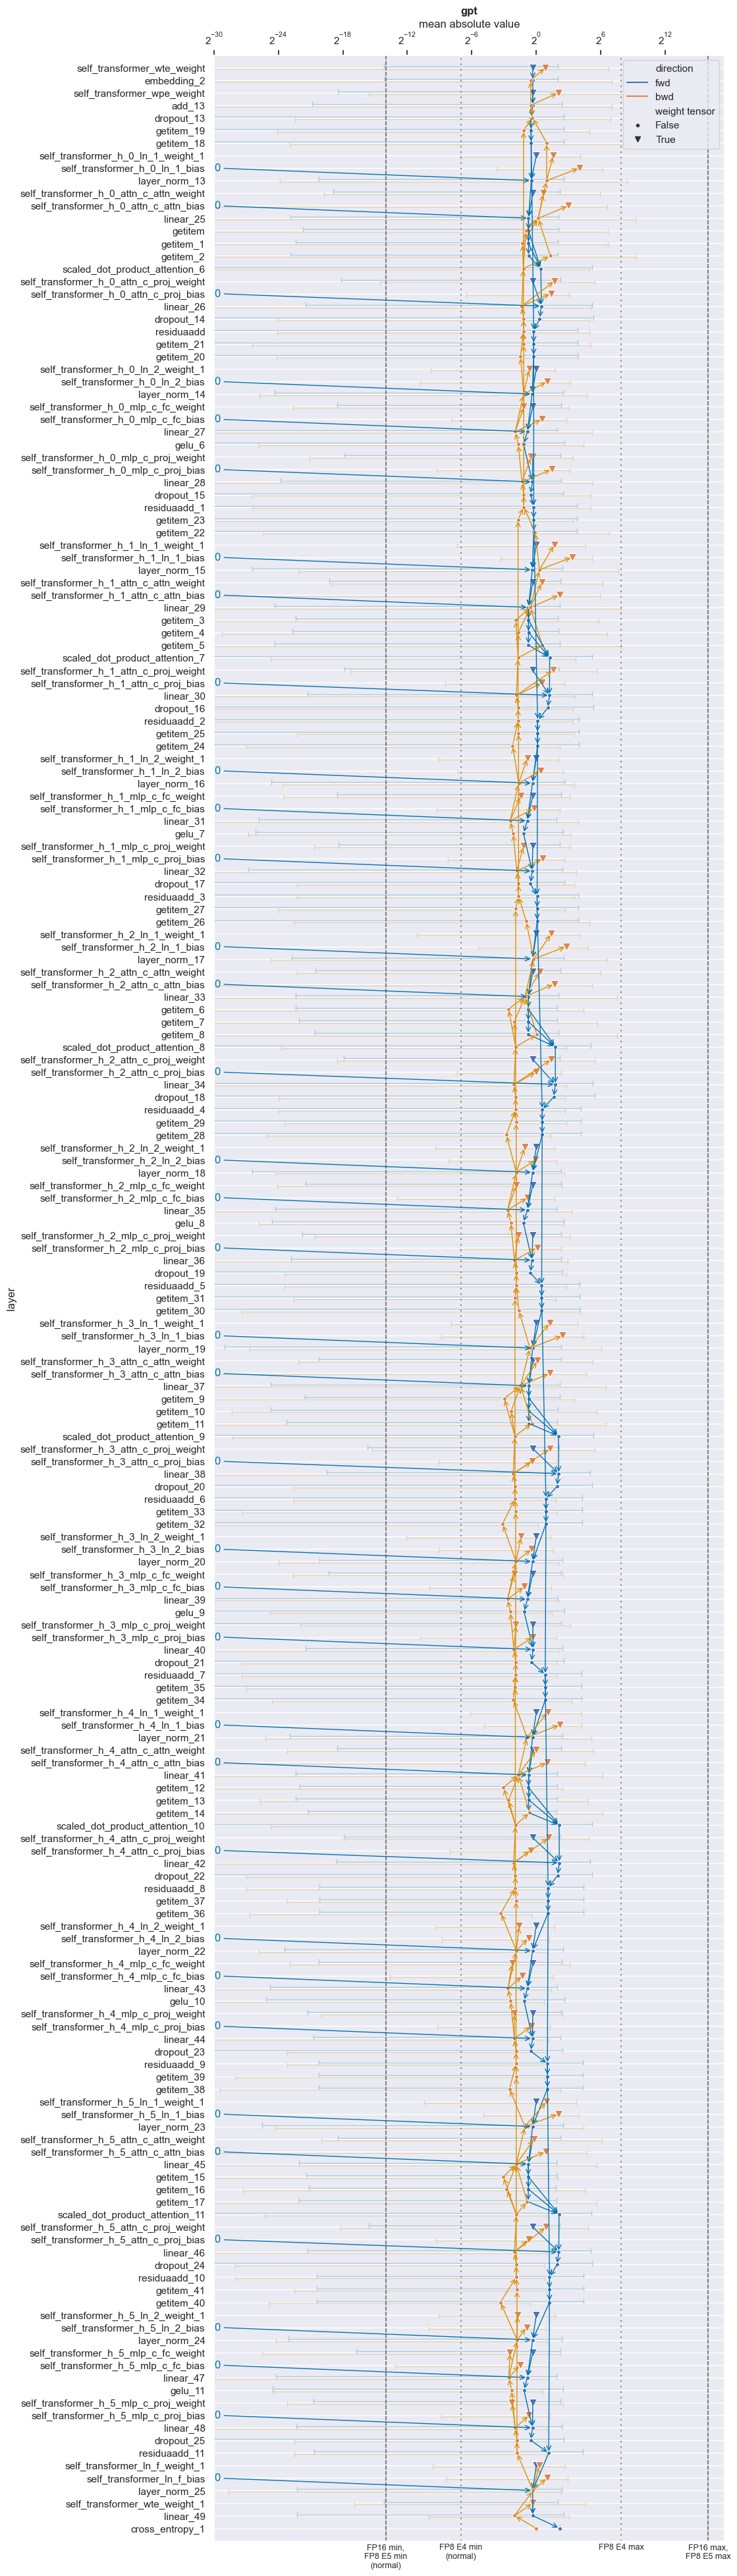

In [11]:
tracked_unit_scaled_gpt = track_scales(unit_scale(gpt))
out, loss = tracked_unit_scaled_gpt(inputs, labels)
loss.backward()

graph = tracked_unit_scaled_gpt.scales_graph()  # type: ignore
analysis.plot(graph, "gpt", xmin=2**-30)

[TODO] Conclusion encouraging users to try unit-scaled training; offering our support; warn that there will be bugs / missing features

(also mention somewhere costs of doing US - i.e. none. We maybe should add in compile transform too. Not sure if it's too small-scale here to benefit. Either way - we should point users to our scale-fusion analysis notebook)